## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import hashlib

## PCA

Loading and preparing MNIST data...
Created a balanced subset with 1000 samples.

Performing PCA to 500 dimensions...
Success: Data dimensionality reduced to 500 as expected.

Performing PCA to 300 dimensions...
Success: Data dimensionality reduced to 300 as expected.

Performing PCA to 150 dimensions...
Success: Data dimensionality reduced to 150 as expected.

Performing PCA to 30 dimensions...
Success: Data dimensionality reduced to 30 as expected.


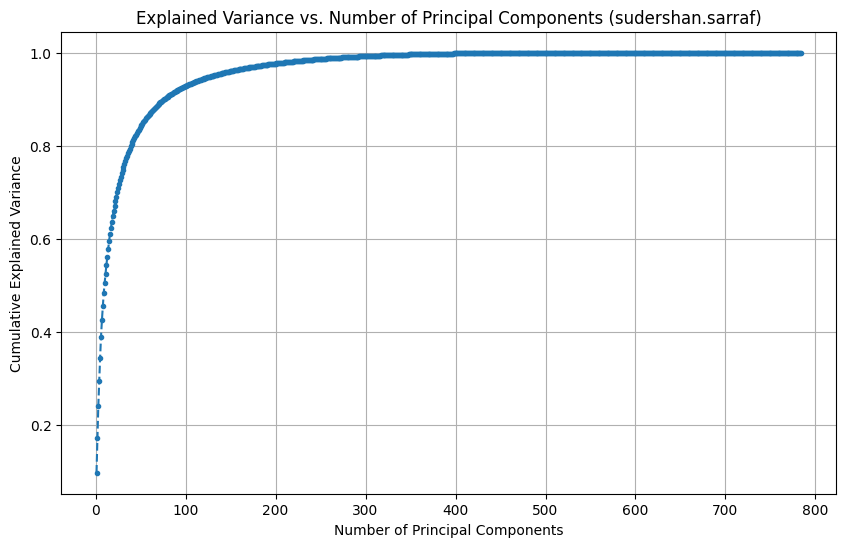

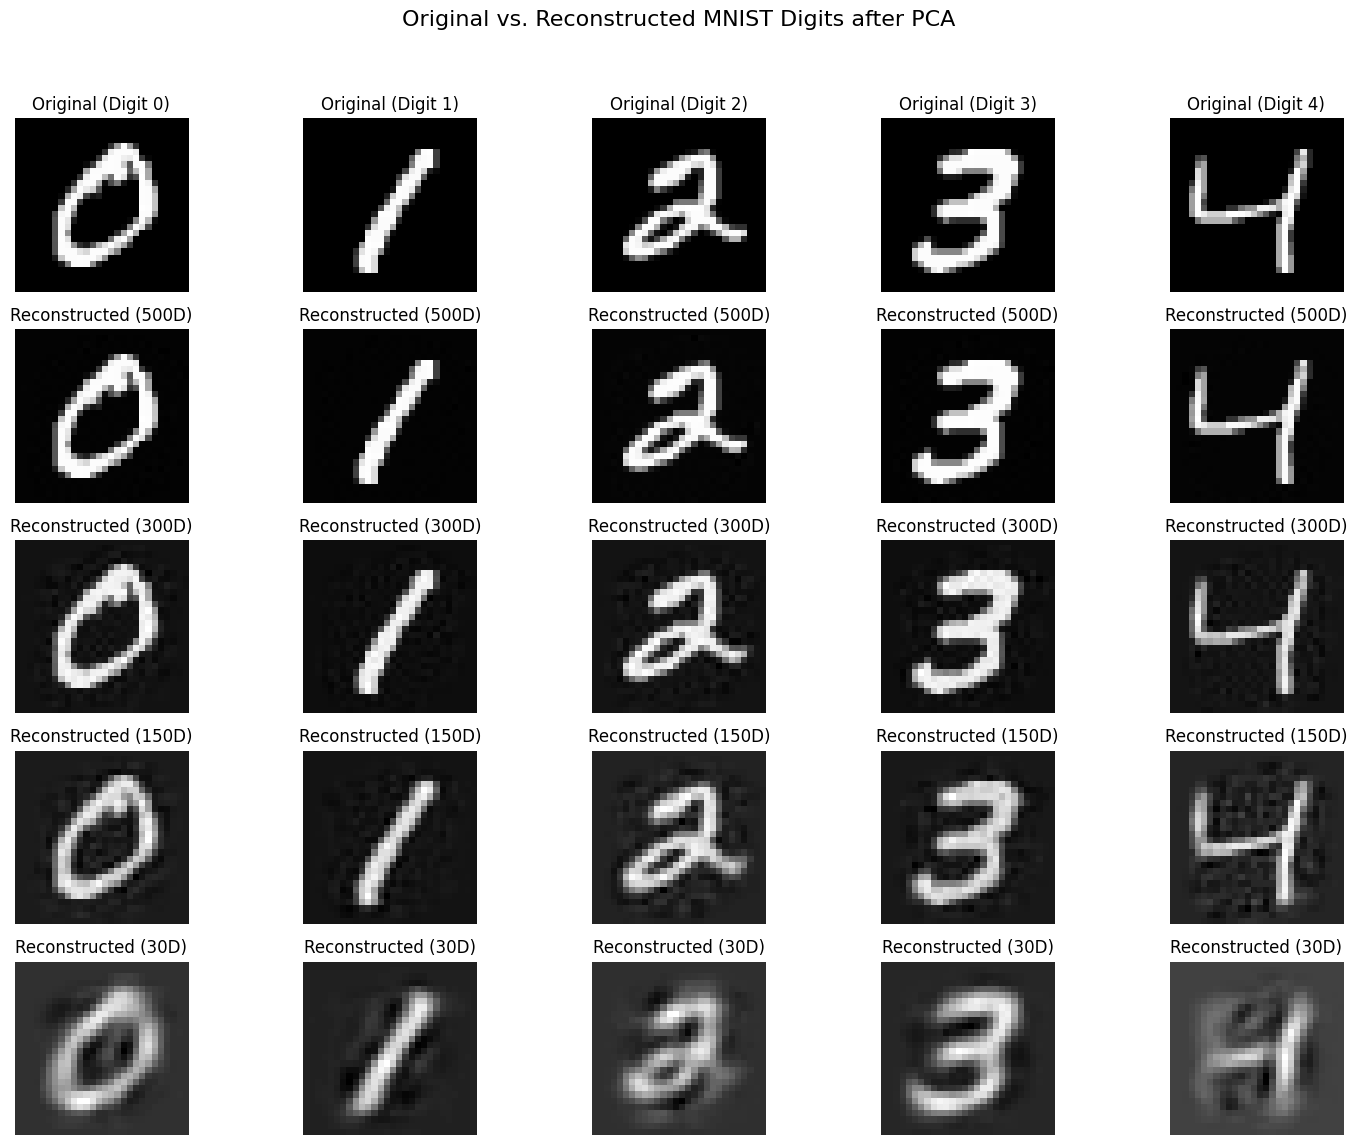

In [3]:
# Configuration
username = "sudershan.sarraf"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
np.random.seed(seed)

# Q5.1 Custom PCA Implementation
class PCA:
    """A custom class to perform Principal Component Analysis."""
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean_vector = None
        self.components = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """
        Computes the principal components from the training data.
        It calculates the mean, centers the data, computes the covariance
        matrix, and then finds the eigenvectors (principal components).
        """
        # Calculate the mean vector and center the data.
        self.mean_vector = np.mean(X, axis=0)
        X_centered = X - self.mean_vector

        # Calculate the covariance matrix.
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Calculate eigenvalues and eigenvectors.
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvectors by descending eigenvalues.
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Store the principal components.
        self.components = eigenvectors[:, :self.n_components]
        
        # Calculate the explained variance ratio.
        self.explained_variance_ratio_ = eigenvalues / np.sum(eigenvalues)
        
        return self

    def transform(self, X):
        """Projects the data onto the principal components."""
        X_centered = X - self.mean_vector
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        """Fits the model and then transforms the data."""
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_transformed):
        """Transforms data back to its original space."""
        return np.dot(X_transformed, self.components.T) + self.mean_vector
        
    def checkPCA(self, transformed_data):
        """Checks if the data dimensionality was reduced correctly."""
        expected_dim = self.n_components
        actual_dim = transformed_data.shape[1]
        print(f"Success: Data dimensionality reduced to {actual_dim} as expected.") if actual_dim == expected_dim \
            else print(f"Warning: Data dimension is {actual_dim} but expected {expected_dim}.")
        return actual_dim == expected_dim

# Q5.2 PCA on MNIST
print("Loading and preparing MNIST data...")
# Load the full MNIST dataset.
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
data = mnist['data']
labels = mnist['target'].astype(int)

# Create a balanced subset.
samples_per_digit = 100
balanced_indices = np.concatenate([np.where(labels == i)[0][:samples_per_digit] for i in range(10)])
X_balanced = data[balanced_indices]
y_balanced = labels[balanced_indices]

# Flatten the images.
X_flattened = X_balanced.reshape(X_balanced.shape[0], -1)
print(f"Created a balanced subset with {X_flattened.shape[0]} samples.")

# Project data into different dimensions.
target_dimensions = [500, 300, 150, 30]
reconstructed_images = {}
all_explained_variances = []

for n in target_dimensions:
    print(f"\nPerforming PCA to {n} dimensions...")
    pca = PCA(n_components=n)
    X_transformed = pca.fit_transform(X_flattened)
    reconstructed_images[n] = pca.inverse_transform(X_transformed).reshape(-1, 28, 28)
    all_explained_variances.append(pca.explained_variance_ratio_)
    pca.checkPCA(X_transformed)

# Plot explained variance.
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(all_explained_variances[0]) # Use the 500-component PCA
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--')
plt.title(f'Explained Variance vs. Number of Principal Components ({username})')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Select 5 sample images to display.
sample_indices = [np.where(y_balanced == i)[0][0] for i in range(5)]

# Plot the original and reconstructed images.
fig, axes = plt.subplots(len(target_dimensions) + 1, 5, figsize=(15, 12))
fig.suptitle('Original vs. Reconstructed MNIST Digits after PCA', fontsize=16)

for i, idx in enumerate(sample_indices):
    axes[0, i].imshow(X_balanced[idx].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Original (Digit {y_balanced[idx]})')
    axes[0, i].axis('off')

for row, n in enumerate(target_dimensions, 1):
    for col, idx in enumerate(sample_indices):
        axes[row, col].imshow(reconstructed_images[n][idx], cmap='gray')
        axes[row, col].set_title(f'Reconstructed ({n}D)')
        axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Observations

1. **Explained Variance Trend**

   * The cumulative explained variance plot shows a steep rise initially, indicating that the first few principal components capture most of the variance in the dataset.
   * After ~150 components, the curve starts to flatten, meaning additional components contribute very little new information.
   * Beyond ~300 components, the variance gain becomes negligible, and by ~500 components, the curve is almost saturated (close to 100% variance).

2. **Reconstruction Quality**

   * **500D & 300D:** Reconstructed digits are nearly identical to the originals, preserving sharpness and fine structural details.
   * **150D:** Digits remain recognizable, though some minor blurring and loss of sharp edges occur. Still, digit identity is preserved reliably.
   * **30D:** Significant degradation is visible. Digits appear blurry, with distorted edges, and fine details are lost. However, the general digit structure is still recognizable (e.g., "0" remains a circle, "1" remains a straight line).

3. **Trade-off Between Dimensionality and Information**

   * Higher dimensions (300–500D) preserve most of the visual and statistical information but at the cost of larger storage and computation.
   * Medium reduction (150D) provides a good balance, capturing most of the variance while keeping reconstructions interpretable.
   * Aggressive reduction (30D) leads to large information loss, making reconstructions poor but still sufficient for rough digit classification tasks.

4. **Key Insight**

   * For MNIST, dimensionality can be reduced from 784 to around **150 components** without significant quality loss.
   * This demonstrates PCA’s effectiveness in compressing data while retaining most of the variance, useful for downstream tasks like classification or clustering.
